# Fly me to the Moon 



### Intro to Data Science Project 1
#### Fall 2021
#### Rena Repenning and Eddy Salazar

Collaboration plan: Rena and Eddy have talked over text and facetime and used Colabs to simultaneously edit the document. We both began steps 1-3 on our own, put them on Colab and then worked together on 3 and 4. We also took turns bringing our questions to office hours.

Sources:
Colab Documentation, 
[Colab "Web Scraping 101"](https://colab.research.google.com/github/jirvingphd/my_data_science_notes/blob/master/Web_Scraping_101_share.ipynb#scrollTo=bDQT-D171lhn), Eli, Phil, see inline citations for various StackOverflow/Documentation links

# Part 1: Data scraping and Preparation


## Step 1: Scrape Your Competitor's Data

Use Python to scrape data for the top 50 solar flares shown in SpaceWeatherLive.com

In [85]:
## Instals for Colab - do not have to run more than once
#!pip install beautifulsoup4, requests, pandas, numpy, lxml
#!pip3 install json

In [86]:
## 1 Imports
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) #Pandas display helpers
import lxml
import json

In [87]:
link = "https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares.html"

# trick server into thinking query is human
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

## 2/3 extract text from the page
r = requests.get(link, headers = headers)
# r.text #--> returns an html mess

## 4 use BS to parse
rootSoup = BeautifulSoup( r.content, "html.parser")

## 5 prettify to view & find appropriate table
# print(rootSoup.prettify())

## 6 save table as variable
t = rootSoup.find("table")

## 7 use pandas to read in the html file 
myHTML = pd.read_html(str(t)) # read html tables into a list of data frame objects
df = myHTML[0] #get table from html

## 8 set names for table columns
df.columns = ["rank", "x_class", "date", "region", "start_time", "max_time", "end_time", "movie"]
# display
df[:10]

,rank,x_class,date,region,start_time,max_time,end_time,movie
0,1,X28+,2003/11/04,486,19:29,19:53,20:06,MovieView archive
1,2,X20+,2001/04/02,9393,21:32,21:51,22:03,MovieView archive
2,3,X17.2+,2003/10/28,486,09:51,11:10,11:24,MovieView archive
3,4,X17+,2005/09/07,808,17:17,17:40,18:03,MovieView archive
4,5,X14.4,2001/04/15,9415,13:19,13:50,13:55,MovieView archive
5,6,X10,2003/10/29,486,20:37,20:49,21:01,MovieView archive
6,7,X9.4,1997/11/06,8100,11:49,11:55,12:01,MovieView archive
7,8,X9.3,2017/09/06,2673,11:53,12:02,12:10,MovieView archive
8,9,X9,2006/12/05,930,10:18,10:35,10:45,MovieView archive
9,10,X8.3,2003/11/02,486,17:03,17:25,17:39,MovieView archive


## Step 2: Tidy the Top 50 Solar Flare Data

In [88]:
## 1 Drop the last column of the table, since we are not going to use it moving forward.
# cite: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
df.drop(columns=['movie'],inplace = True)

## 2 Use the datetime library to combine the date and each of the three time columns into three datetime columns. You will see why this is useful later on.
import datetime

## 3 Update the values in the dataframe as you do this. The Pandas function .at should prove useful.
df['start_time'] = pd.to_datetime(df['date'] + ' ' + df['start_time'])
df['max_time'] = pd.to_datetime(df['date'] + ' ' + df['max_time'])
df['end_time'] = pd.to_datetime(df['date'] + ' ' + df['end_time'])
# df.start_time.dtype # check column dtype
 
## 4 Set regions coded as - as missing (np.nan)
df.replace(to_replace = '-',value = np.nan)

## 5 Re-arrange the columns and drop the date as shown below.
df.rename(columns = {"start_time":"start_datetime", "max_time":"max_datetime", "end_time":"end_datetime"},inplace = True)
df.drop(columns=['date'],inplace = True)
df = df[['rank','x_class','start_datetime','max_datetime','end_datetime','region']]

df[:11] # show first 11 entries

,rank,x_class,start_datetime,max_datetime,end_datetime,region
0,1,X28+,2003-11-04 19:29:00,2003-11-04 19:53:00,2003-11-04 20:06:00,486
1,2,X20+,2001-04-02 21:32:00,2001-04-02 21:51:00,2001-04-02 22:03:00,9393
2,3,X17.2+,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:24:00,486
3,4,X17+,2005-09-07 17:17:00,2005-09-07 17:40:00,2005-09-07 18:03:00,808
4,5,X14.4,2001-04-15 13:19:00,2001-04-15 13:50:00,2001-04-15 13:55:00,9415
5,6,X10,2003-10-29 20:37:00,2003-10-29 20:49:00,2003-10-29 21:01:00,486
6,7,X9.4,1997-11-06 11:49:00,1997-11-06 11:55:00,1997-11-06 12:01:00,8100
7,8,X9.3,2017-09-06 11:53:00,2017-09-06 12:02:00,2017-09-06 12:10:00,2673
8,9,X9,2006-12-05 10:18:00,2006-12-05 10:35:00,2006-12-05 10:45:00,930
9,10,X8.3,2003-11-02 17:03:00,2003-11-02 17:25:00,2003-11-02 17:39:00,486


## Step 3: Scrape the NASA Data


In [89]:
nasalink = "https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html"
# use requests to get the url
rnasa = requests.get(nasalink, headers = headers)

## 1 Use beautiful soup to extract data as a long string
nasarootSoup = BeautifulSoup( rnasa.content, "html.parser")

## 2 Use str.split and list comprehensions or similar to separate each line of text into a data row. 
nasa_text = nasarootSoup.get_text()
# split text into its rows
resultofsplit1 = [x.strip() for x in nasa_text.split('\n')]
# will store second split where rows are split into row x column 2d list
resultofsplit2 = []
# remove headers for data
del resultofsplit1[0:15]
# split rows into rows x columns and remove extra whitespace
for item in resultofsplit1:
  tempstring = item.split(" ")
  resultofsplit2.append(list(filter(None, tempstring)))

## 3 create data frame from 2d list
df2 = pd.DataFrame(resultofsplit2)
# remove extra columns and rows
df2.drop(df2.iloc[:, 14:24],inplace = True, axis = 1) ## removed 14
df2.drop(df2.index[[522,523,524]],axis = 0,inplace = True)

# reorder columns to match example
df2 = df2[[9, 10, 11, 2, 5, 3, 6, 7, 8, 13, 0, 4, 1, 12]]
# rename columns to match example
df2.columns = ["cme_date", "cme_time", "cpa", "end_date", "end_frequency", "end_time", "flare_location", "flare_region", "importance", "speed",  "start_date", "start_frequency", "start_time", "width"]
df2[:11] #show first 11 entries

,cme_date,cme_time,cpa,end_date,end_frequency,end_time,flare_location,flare_region,importance,speed,start_date,start_frequency,start_time,width
0,04/01,15:18,74,04/01,4000,14:15,S25E16,8026,M1.3,312,1997/04/01,8000,14:00,79
1,04/07,14:27,Halo,04/07,1000,17:30,S28E19,8027,C6.8,878,1997/04/07,11000,14:30,360
2,05/12,05:30,Halo,05/14,80,16:00,N21W08,8038,C1.3,464,1997/05/12,12000,05:15,360
3,05/21,21:00,263,05/21,500,22:00,N05W12,8040,M1.3,296,1997/05/21,5000,20:20,165
4,09/23,22:02,133,09/23,2000,22:16,S29E25,8088,C1.4,712,1997/09/23,6000,21:53,155
5,11/03,05:28,240,11/03,250,12:00,S20W13,8100,C8.6,227,1997/11/03,14000,05:15,109
6,11/03,11:11,233,11/03,5000,11:30,S16W21,8100,M4.2,352,1997/11/03,14000,10:30,122
7,11/04,06:10,Halo,11/05,100,04:30,S14W33,8100,X2.1,785,1997/11/04,14000,06:00,360
8,11/06,12:10,Halo,11/07,100,08:30,S18W63,8100,X9.4,1556,1997/11/06,14000,12:20,360
9,11/27,13:56,98,11/27,7000,14:00,N17E63,8113,X2.6,441,1997/11/27,14000,13:30,91


## Part 4: Tidy the NASA Table

Code missing observations properly, recode columns that corrospond to more than one piece of information, and treat dates and times appropriately.

In [90]:
## 1 Recode any missing entries as np.nan
# Inorder of final columns (only those included)
df2["cme_date"][(df2.cme_date == "--/--") | (df2.cme_date == "FILA")] = np.nan  #Eli: df2[col_name][boolean_mask], df2.replace(to_replace="--/--", value=np.nan  )
df2["start_date"][(df2.start_date == "--/--")| (df2.start_date == "FILA")] = np.nan 
df2["end_date"][(df2.end_date == "--/--")| (df2.start_date == "FILA")] = np.nan
df2["cme_time"][df2.cme_time == "FILA"] = np.nan
df2["start_time"][df2.start_time == "FILA"] = np.nan
df2["end_time"][df2.end_time == "FILA"] = np.nan
df2["cme_time"][df2.cme_time == "24:00"] = "23:59"
df2["start_time"][df2.start_time == "24:00"] = "23:59"
df2["end_time"][df2.end_time == "24:00"] = "23:59"
df2["start_frequency"][df2.start_frequency == "????"] = np.nan
df2["end_frequency"][df2.end_frequency == "????"] = np.nan
df2["flare_location"][df2.flare_location == "-----"] = np.nan
df2["flare_region"][(df2.flare_region == "-----")|(df2.flare_region == "EP")|(df2.flare_region == "EP?")] = np.nan
df2["flare_region"][df2.flare_region == "DSF"] = "FILA"
df2["importance"][df2.importance == "----"] = np.nan

## 2 Create new column that specifies if row is halo
df2["is_flare"] = (df2["cpa"] == "Halo")
# replace halo entries in cme_angle as np.nan
df2["cpa"][df2.cpa == "Halo"]=np.nan

## 3 The width column indicates if the given value is a lower bound - create is "width_lower_bound" column
# extract out only digits from the width column
df2["width_lower_bound"] = (df2.width.str[0] == ">")
df2["width"] = df2.width.str.extract('(\d+)') #Eli

from datetime import date # Source: Emily Powers
## 4 Combine date and time columns for start, end, and cme --> datetime objects
df2["start_datetime"] = pd.to_datetime(df2['start_date'] + ' ' + df2['start_time'], infer_datetime_format=True) 
# add year series to the column
df2["year"] = pd.DatetimeIndex(df2['start_date']).year.astype("str") 
df2["end_datetime"] = pd.to_datetime( df2["year"] +' '+ df2['end_date'] + ' ' + df2['end_time'], infer_datetime_format=True)
df2["cme_datetime"] = pd.to_datetime( df2["year"] +' '+ df2['cme_date'] + ' ' + df2['cme_time'], infer_datetime_format=True)

## 5 Clean data
# Convert numerical values to float64 type # Eli advice
df2['start_frequency']=pd.to_numeric(df2['start_frequency'], errors='coerce', downcast='unsigned') # Cite: Phil's help
df2['end_frequency']=pd.to_numeric(df2['end_frequency'], errors='coerce', downcast='unsigned')
df2['flare_region']=pd.to_numeric(df2['flare_region'], errors='coerce', downcast='unsigned')
df2['cpa']=pd.to_numeric(df2['cpa'], errors='coerce')
df2['width']=pd.to_numeric(df2['width'], errors='coerce')
df2['speed']=pd.to_numeric(df2['speed'], errors='coerce', downcast='unsigned')

# drop unessesary columns
df2.drop(columns=["start_time", "start_date", "end_time", "end_date", "cme_time", "cme_date"], inplace=True) # Cite: https://www.kite.com/python/answers/how-to-reorder-columns-in-a-pandas-dataframe-in-python
# reindex to change order
df2 = df2.reindex(columns=["start_datetime", "end_datetime", "start_frequency", "end_frequency", "flare_location", "flare_region", "importance","cme_datetime", "cpa", "width", "speed", "is_flare", "width_lower_bound"])

df2[:11] # display first 11 rows



,start_datetime,end_datetime,start_frequency,end_frequency,flare_location,flare_region,importance,cme_datetime,cpa,width,speed,is_flare,width_lower_bound
0,1997-04-01 14:00:00,1997-04-01 14:15:00,8000.0,4000.0,S25E16,8026.0,M1.3,1997-04-01 15:18:00,74.0,79.0,312.0,False,False
1,1997-04-07 14:30:00,1997-04-07 17:30:00,11000.0,1000.0,S28E19,8027.0,C6.8,1997-04-07 14:27:00,NaN,360.0,878.0,True,False
2,1997-05-12 05:15:00,1997-05-14 16:00:00,12000.0,80.0,N21W08,8038.0,C1.3,1997-05-12 05:30:00,NaN,360.0,464.0,True,False
3,1997-05-21 20:20:00,1997-05-21 22:00:00,5000.0,500.0,N05W12,8040.0,M1.3,1997-05-21 21:00:00,263.0,165.0,296.0,False,False
4,1997-09-23 21:53:00,1997-09-23 22:16:00,6000.0,2000.0,S29E25,8088.0,C1.4,1997-09-23 22:02:00,133.0,155.0,712.0,False,False
5,1997-11-03 05:15:00,1997-11-03 12:00:00,14000.0,250.0,S20W13,8100.0,C8.6,1997-11-03 05:28:00,240.0,109.0,227.0,False,False
6,1997-11-03 10:30:00,1997-11-03 11:30:00,14000.0,5000.0,S16W21,8100.0,M4.2,1997-11-03 11:11:00,233.0,122.0,352.0,False,False
7,1997-11-04 06:00:00,1997-11-05 04:30:00,14000.0,100.0,S14W33,8100.0,X2.1,1997-11-04 06:10:00,NaN,360.0,785.0,True,False
8,1997-11-06 12:20:00,1997-11-07 08:30:00,14000.0,100.0,S18W63,8100.0,X9.4,1997-11-06 12:10:00,NaN,360.0,1556.0,True,False
9,1997-11-27 13:30:00,1997-11-27 14:00:00,14000.0,7000.0,N17E63,8113.0,X2.6,1997-11-27 13:56:00,98.0,91.0,441.0,False,False


# Part 2: Analysis

## 1. Replicate

Replicate the top 50 solar flare table in SpaceWeatherLive.com exactly using the data obtained from NASA.



#### Organizing SWL data and sorting by rating numerically

Data From Part 1.1

In [91]:
# space weather live data from Part 1
swl_ranks = df[['x_class', 'start_datetime', 'end_datetime', 'max_datetime']]

# extract out numbers --> we will rank numbers without the + using x_class
swl_ranks["x_class"] = swl_ranks.x_class.str.extract('(.{0,3}[^+])')
# Make a sorting column numberic so it will not sort alphanumerically
swl_ranks["sorting_column"] = pd.to_numeric(swl_ranks["x_class"].str[1:]) #errors=coerce
# rearrage
swl_ranks = swl_ranks[['x_class', 'start_datetime', 'end_datetime','max_datetime', 'sorting_column',]]

swl_ranks = swl_ranks.sort_values("sorting_column", ascending=False)
swl_ranks

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,x_class,start_datetime,end_datetime,max_datetime,sorting_column
0,X28,2003-11-04 19:29:00,2003-11-04 20:06:00,2003-11-04 19:53:00,28.0
1,X20,2001-04-02 21:32:00,2001-04-02 22:03:00,2001-04-02 21:51:00,20.0
2,X17.,2003-10-28 09:51:00,2003-10-28 11:24:00,2003-10-28 11:10:00,17.0
3,X17,2005-09-07 17:17:00,2005-09-07 18:03:00,2005-09-07 17:40:00,17.0
4,X14.,2001-04-15 13:19:00,2001-04-15 13:55:00,2001-04-15 13:50:00,14.0
5,X10,2003-10-29 20:37:00,2003-10-29 21:01:00,2003-10-29 20:49:00,10.0
6,X9.4,1997-11-06 11:49:00,1997-11-06 12:01:00,1997-11-06 11:55:00,9.4
7,X9.3,2017-09-06 11:53:00,2017-09-06 12:10:00,2017-09-06 12:02:00,9.3
8,X9,2006-12-05 10:18:00,2006-12-05 10:45:00,2006-12-05 10:35:00,9.0
9,X8.3,2003-11-02 17:03:00,2003-11-02 17:39:00,2003-11-02 17:25:00,8.3


#### Organizing and sorting NASA data

**Importance** - Soft X-ray flare size (peak flux in the 1-8)A channel. Nan means the soft X-ray flux is not available.



https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2_description.htm

In [92]:
# # drop unessesary columns
df2_flareRank = df2[['importance', 'start_datetime', 'end_datetime','start_frequency', 'end_frequency']]

# get the top frequencies which have an X prefix -- we know this because all SWL entries have X
df2_flareRank = df2_flareRank[df2_flareRank["importance"].str[0] == "X"]

# Borrowing our code from above...
df2_flareRank["sortColNum"] = df2_flareRank['importance'].str[1:]
# extract out numbers --> we will rank numbers without the +
df2_flareRank["sorting_column"] = df2_flareRank.sortColNum.str.extract('(.{0,3}[^+])')
# Change rank column to numberic so it will not sort alphanumerically
df2_flareRank["sorting_column"] = pd.to_numeric(df2_flareRank["sorting_column"]) #errors=coerce

df2_flareRank["x_class"] = df2_flareRank['importance']
# Drop sortColNum and order
df2_flareRank = df2_flareRank[["x_class", 'start_datetime', 'end_datetime', "sorting_column"]]

# show top fifty
df2_flareRank[:50]


,x_class,start_datetime,end_datetime,sorting_column
7,X2.1,1997-11-04 06:00:00,1997-11-05 04:30:00,2.1
8,X9.4,1997-11-06 12:20:00,1997-11-07 08:30:00,9.4
9,X2.6,1997-11-27 13:30:00,1997-11-27 14:00:00,2.6
14,X1.2,1998-04-23 06:00:00,1998-04-23 15:30:00,1.2
16,X1.0,1998-04-27 09:20:00,1998-04-27 10:00:00,1.0
18,X1.1,1998-05-02 14:25:00,1998-05-02 14:50:00,1.1
19,X2.7,1998-05-06 08:25:00,1998-05-06 08:35:00,2.7
46,X1.1,1999-08-28 18:25:00,1999-08-28 18:33:00,1.1
49,X1.8,1999-10-14 09:10:00,1999-10-14 10:00:00,1.8
55,X1.2,2000-02-05 19:34:00,2000-02-05 19:38:00,1.2


#### Check to see if we get the same data.

We will assume that same start/end datetime has to mean same flare. Also we want merge on `'x_class'` and `'sorting_column'` because they would have to be the same.

We get no entries where we can inner join on ```["x_class", 'sorting_column', 'start_datetime', 'end_datetime']```


In [93]:
swl_ranks.merge(df2_flareRank, on=["x_class", 'sorting_column', 'start_datetime', 'end_datetime'], how="inner", suffixes=["_swl", "_nasa"])

,x_class,start_datetime,end_datetime,max_datetime,sorting_column


We then use inner merge on only the sorting column we have cleaned. `x_class` isn't perfect because the data isn't entered exactly the same in both sources. We can infer that sorting column holds the correct magnitude from what we know about the two sources.

In [94]:
df_w_inner = swl_ranks.merge(df2_flareRank, on=['sorting_column'], how="inner", suffixes=["_swl", "_nasa"])
df_w_inner = df_w_inner[['x_class_swl', 'x_class_nasa', 'start_datetime_swl', 'start_datetime_nasa', 'max_datetime', 'end_datetime_swl', 'end_datetime_nasa', 'sorting_column']]
df_w_inner[:10]

,x_class_swl,x_class_nasa,start_datetime_swl,start_datetime_nasa,max_datetime,end_datetime_swl,end_datetime_nasa,sorting_column
0,X28,X28.,2003-11-04 19:29:00,2003-11-04 20:00:00,2003-11-04 19:53:00,2003-11-04 20:06:00,2003-11-04 23:59:00,28.0
1,X20,X20.,2001-04-02 21:32:00,2001-04-02 22:05:00,2001-04-02 21:51:00,2001-04-02 22:03:00,2001-04-03 02:30:00,20.0
2,X17.,X17.,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:10:00,2003-10-28 11:24:00,2003-10-29 23:59:00,17.0
3,X17,X17.,2005-09-07 17:17:00,2003-10-28 11:10:00,2005-09-07 17:40:00,2005-09-07 18:03:00,2003-10-29 23:59:00,17.0
4,X14.,X14.,2001-04-15 13:19:00,2001-04-15 14:05:00,2001-04-15 13:50:00,2001-04-15 13:55:00,2001-04-16 13:00:00,14.0
5,X10,X10.,2003-10-29 20:37:00,2003-10-29 20:55:00,2003-10-29 20:49:00,2003-10-29 21:01:00,2003-10-29 23:59:00,10.0
6,X9.4,X9.4,1997-11-06 11:49:00,1997-11-06 12:20:00,1997-11-06 11:55:00,1997-11-06 12:01:00,1997-11-07 08:30:00,9.4
7,X9.3,X9.3,2017-09-06 11:53:00,2017-09-06 12:05:00,2017-09-06 12:02:00,2017-09-06 12:10:00,2017-09-07 08:00:00,9.3
8,X9,X9.0,2006-12-05 10:18:00,2006-12-05 10:50:00,2006-12-05 10:35:00,2006-12-05 10:45:00,2006-12-05 20:00:00,9.0
9,X8.3,X8.3,2003-11-02 17:03:00,2003-11-02 17:30:00,2003-11-02 17:25:00,2003-11-02 17:39:00,2003-11-03 01:00:00,8.3


### Write a sentence or two discussing how well you can replicate the SpaceWeatherLive data from the NASA data.

> We can get the top fifty flares from NASA, with the same magniatude as from SWL, but without the same date and time. From looking at the plain data we infer that this discrepancy is due to data collection, and not different observations.
> The tables have no entries with exactly the same rating and datetimes. We know this because inner join produced nothing.
> 


## 2. Integration
Function to merge SWL rankings with origional NASA table


#### Matching fxn - **flareTimeSimilarity(df)**

We assume that the input data frame will only have merged rankings for `importance[0] == "X"`. We will also only feed in the same rating.



In [95]:
# time similarity --> Eli
# https://stackoverflow.com/questions/1345827/how-do-i-find-the-time-difference-between-two-datetime-objects-in-python?rq=1
def flareTimeSimilarity(df):
  df["SameDay"] = False
  for i in range(len(df.index)): #https://www.kite.com/python/answers/how-to-count-the-number-of-rows-in-a-pandas-dataframe-in-python
    delta_s = df["start_datetime_x"][i] - df["start_datetime_y"][i]
    delta_e = df["end_datetime_x"][i] - df["end_datetime_y"][i]
    # We will give the solare flares 12 hours of leeway to being the same one
    if (delta_s.seconds <= 14400) and (delta_e.seconds <= 14400):
      df["SameDay"] = True

  return df


Merge tables and apply function

In [96]:
# use origional nasa table
nasa_df = df2
# add column 1-50 for rank 
swl_ranks["Rank"] = pd.Series(range(1,51))\
# DF of just info we need for the ranks
swl_ranks = swl_ranks[["Rank", "x_class", "start_datetime", "end_datetime"]]

nasa_df['x_class'] = nasa_df['importance']
nasa_df.drop(columns=["importance"])

ranked_df = nasa_df.merge(swl_ranks, how="left", on=["x_class"])

ranked_df = flareTimeSimilarity(ranked_df)

Now, display only the top fifty rankings

In [97]:
finalNasa = ranked_df[~(ranked_df["Rank"].isna()) & (ranked_df["SameDay"]==True) ]
finalNasa
## now showing all that are ranked and occured in the same four hour windows

,start_datetime_x,end_datetime_x,start_frequency,end_frequency,flare_location,flare_region,importance,cme_datetime,cpa,width,speed,is_flare,width_lower_bound,x_class,Rank,start_datetime_y,end_datetime_y,SameDay
8,1997-11-06 12:20:00,1997-11-07 08:30:00,14000.0,100.0,S18W63,8100.0,X9.4,1997-11-06 12:10:00,NaN,360.0,1556.0,True,False,X9.4,7.0,1997-11-06 11:49:00,1997-11-06 12:01:00,True
9,1997-11-27 13:30:00,1997-11-27 14:00:00,14000.0,7000.0,N17E63,8113.0,X2.6,1997-11-27 13:56:00,98.0,91.0,441.0,False,False,X2.6,49.0,2005-01-15 22:25:00,2005-01-15 23:31:00,True
10,1997-11-27 13:30:00,1997-11-27 14:00:00,14000.0,7000.0,N17E63,8113.0,X2.6,1997-11-27 13:56:00,98.0,91.0,441.0,False,False,X2.6,50.0,2001-09-24 09:32:00,2001-09-24 11:09:00,True
20,1998-05-06 08:25:00,1998-05-06 08:35:00,14000.0,5000.0,S11W65,8210.0,X2.7,1998-05-06 08:29:00,309.0,190.0,1099.0,False,False,X2.7,46.0,2015-05-05 22:05:00,2015-05-05 22:15:00,True
21,1998-05-06 08:25:00,1998-05-06 08:35:00,14000.0,5000.0,S11W65,8210.0,X2.7,1998-05-06 08:29:00,309.0,190.0,1099.0,False,False,X2.7,47.0,2003-11-03 01:09:00,2003-11-03 01:45:00,True
22,1998-05-06 08:25:00,1998-05-06 08:35:00,14000.0,5000.0,S11W65,8210.0,X2.7,1998-05-06 08:29:00,309.0,190.0,1099.0,False,False,X2.7,48.0,1998-05-06 07:58:00,1998-05-06 08:20:00,True
85,2000-07-14 10:30:00,2000-07-15 14:30:00,14000.0,80.0,N22W07,9077.0,X5.7,2000-07-14 10:54:00,NaN,360.0,1674.0,True,False,X5.7,17.0,2000-07-14 10:03:00,2000-07-14 10:43:00,True
124,2001-04-06 19:35:00,2001-04-07 01:50:00,14000.0,230.0,S21E31,9415.0,X5.6,2001-04-06 19:30:00,NaN,360.0,1270.0,True,False,X5.6,18.0,2001-04-06 19:10:00,2001-04-06 19:31:00,True
129,2001-04-15 14:05:00,2001-04-16 13:00:00,14000.0,40.0,S20W85,9415.0,X14.,2001-04-15 14:06:00,245.0,167.0,1199.0,False,False,X14.,5.0,2001-04-15 13:19:00,2001-04-15 13:55:00,True
138,2001-08-25 16:50:00,2001-08-25 23:00:00,8000.0,170.0,S17E34,9591.0,X5.3,2001-08-25 16:50:00,NaN,360.0,1433.0,True,False,X5.3,22.0,2001-08-25 16:23:00,2001-08-25 17:04:00,True


### 3. Graph

Prepare one plot that shows the top 50 solar flares that you were able to match in context with all data available in the NASA dataset.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


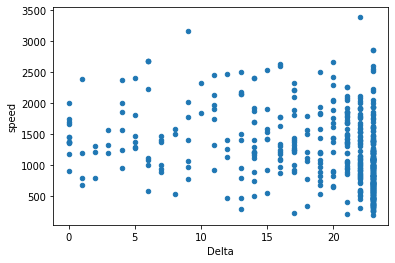

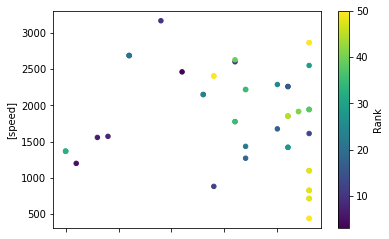

In [98]:
import matplotlib.pyplot as plt

# using a similar function to above --> get delta in time for each
def flareTimeDelta(df):
  df["Delta"] = 0
  for i in range(len(df)): #https://www.kite.com/python/answers/how-to-count-the-number-of-rows-in-a-pandas-dataframe-in-python
    delta_s = df["start_datetime_x"][i] - df["end_datetime_x"][i]
    hours = (delta_s.seconds / 3600)
    df["Delta"][i] = hours
  return df

# all data points
all = flareTimeDelta(ranked_df)
# just the top fifty
ranked = all[~all["Rank"].isna()]

ax = all.plot.scatter(x="Delta", y="speed")
# BLUE: all entries time recorded versus speed
ax = ranked.plot.scatter(x=["Delta"], y=["speed"], c="Rank", colormap='viridis')
# MULTI: all ranked entries, colored by their ranking